In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn import tree



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf



prng = np.random.RandomState(20240417)

In [6]:
# HELPER FUNCTIONS
# create funtion that takes a pipeline model + a name as inputs and creates the submission file needed to evaluate it on the test set
def create_submission_file(model,name):
    # use the x_test to predict the probabilities
    y_predicted = model.predict_proba(x_test)
    # create a submission file with the same format as the submission sample file
    submission = pd.DataFrame({'article_id': test['article_id'],
                                    'score': [x[1] for x in y_predicted]})

    return submission.to_csv(name+'.csv',index=False)

# loss function
def evaluate_model(model):
    y_val_pred = model.predict_proba(x_val)
    print(f'The Validation AUC for the model is {round(roc_auc_score(y_val, [x[1] for x in y_val_pred]),4)}')

In [48]:
train = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Science-Concepts/main/assignment3/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Science-Concepts/main/assignment3/data/test.csv')

In [8]:
# data table containing training data
train.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
0,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,1.000000,-0.153395,-0.4,-0.10,0.0,0.0,0.5,0.0,0,1
1,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,1.000000,-0.308167,-1.0,-0.10,0.0,0.0,0.5,0.0,0,3
2,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.433333,-0.141667,-0.2,-0.05,0.0,0.0,0.5,0.0,0,5
3,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.500000,-0.500000,-0.8,-0.40,0.0,0.0,0.5,0.0,0,6
4,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.800000,-0.441111,-1.0,-0.05,0.0,0.0,0.5,0.0,0,7


In [9]:
# data table containing testing data without y (needs submission for evaluation)
test.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,article_id
0,134,11,217,0.631579,1.0,0.818966,4,2,2,0,...,0.136364,0.5,-0.170370,-0.200000,-0.155556,0.288889,-0.155556,0.211111,0.155556,2
1,415,11,1041,0.489423,1.0,0.700321,22,3,0,14,...,0.050000,1.0,-0.426268,-1.000000,-0.100000,0.975000,0.300000,0.475000,0.300000,4
2,625,9,486,0.599585,1.0,0.727273,4,3,1,0,...,0.062500,0.7,-0.387821,-1.000000,-0.050000,0.000000,0.000000,0.500000,0.000000,10
3,148,14,505,0.509018,1.0,0.718861,8,4,1,1,...,0.100000,1.0,-0.284722,-0.400000,-0.050000,0.000000,0.000000,0.500000,0.000000,13
4,294,14,274,0.620301,1.0,0.726190,5,1,1,0,...,0.100000,0.6,-0.333333,-0.333333,-0.333333,0.000000,0.000000,0.500000,0.000000,26


# Explonatary Data Analysis

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  float64
 11  num_keywords                   29733 non-null  int64  
 12  data_channel_is_lifestyle      29733 non-null 

In [11]:
train.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'glob

In [12]:
print(train.shape)
print(test.shape)

(29733, 61)
(9911, 60)


In [13]:
# check for empty cells
train.columns[train.isnull().any()]

Index([], dtype='object')

We don't have missing values

In [14]:
train.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,...,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,355.645646,10.390812,545.008274,0.555076,1.005852,0.695432,10.912690,3.290788,4.524535,1.263546,...,0.757780,-0.259709,-0.520981,-0.107793,0.281878,0.069691,0.341427,0.155234,0.121649,19834.913530
std,214.288261,2.110135,469.358037,4.064572,6.039655,3.768796,11.316508,3.840874,8.213823,4.189080,...,0.247293,0.128488,0.290454,0.095672,0.323461,0.264379,0.188735,0.225066,0.326886,11432.376037
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.471400,1.000000,0.626126,4.000000,1.000000,1.000000,0.000000,...,0.600000,-0.328704,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,0.000000,9965.000000
50%,342.000000,10.000000,409.000000,0.539894,1.000000,0.690566,8.000000,2.000000,1.000000,0.000000,...,0.800000,-0.252827,-0.500000,-0.100000,0.144444,0.000000,0.500000,0.000000,0.000000,19859.000000
75%,545.000000,12.000000,712.000000,0.609375,1.000000,0.755208,14.000000,4.000000,4.000000,1.000000,...,1.000000,-0.186494,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.250000,0.000000,29742.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,74.000000,111.000000,91.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,1.000000,39643.000000


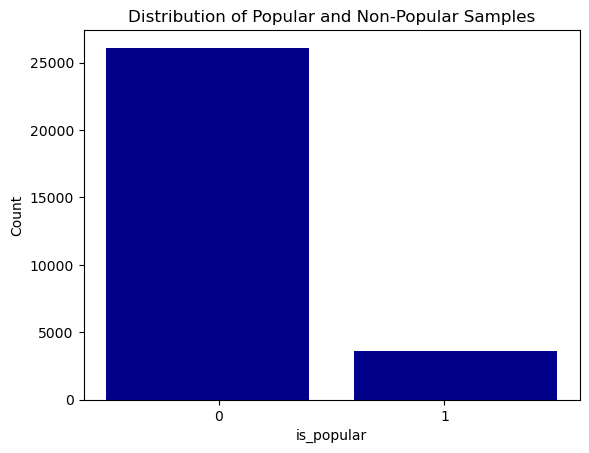

In [15]:
# let's look at our left-hand side variable
# Set ggplot style
train['is_popular'].hist(grid=False,color='darkblue',bins=[-0.5, 0.4,0.6, 1.5])

# Adding labels and title
plt.title('Distribution of Popular and Non-Popular Samples')
plt.xlabel('is_popular')
plt.ylabel('Count')

# Set x-ticks
plt.xticks([0, 1])

# Show plot
plt.show()

In [16]:
# what's the percentage of 1s
print(train['is_popular'].sum() / train['is_popular'].count())

0.12164934584468436


In [17]:
train.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'glob

In [18]:
# let's look at our predictor variable

# Plotting the correlation matrix as a heatmap
# plt.figure(figsize=(30, 30))
# sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Predictor Variables')
# plt.show()

## Data Cleaning

In [19]:
# first look at extreme values and deal with them.
def has_extreme_values(column, threshold_percentage=80):
    """
    Check if a column contains extreme values based on the difference between the maximum value
    and the 95th percentile relative to the mean of the column.
    
    Parameters:
    - column: Pandas Series, the column to check.
    - threshold_percentage: float, the percentage above which the difference between the maximum
                            value and the 95th percentile is considered extreme.
    
    Returns:
    - 1 if extreme values are detected, 0 otherwise.
    """
    max_value = column.max()
    percentile_95 = column.quantile(0.95)
    mean_value = column.mean()
    
    # Calculate the difference between the maximum value and the 95th percentile
    difference = max_value - percentile_95
    
    # Calculate the threshold as a percentage of the mean value
    threshold = threshold_percentage / 100 * mean_value
    
    # Check if the difference exceeds the threshold
    if difference > threshold:
        return 1  # Extreme values detected
    else:
        return 0  # No extreme values detected

# Example usage:
extreme_values_detected = train.apply(has_extreme_values)
print(extreme_values_detected)
print('\n')
print(f'There are {extreme_values_detected.sum()} variables containing extreme values')


timedelta                       0
n_tokens_title                  1
n_tokens_content                1
n_unique_tokens                 1
n_non_stop_words                1
                               ..
title_sentiment_polarity        1
abs_title_subjectivity          0
abs_title_sentiment_polarity    1
is_popular                      0
article_id                      0
Length: 61, dtype: int64


There are 32 variables containing extreme values


In [20]:
train[extreme_values_detected.loc[extreme_values_detected == 1].index.to_list()].describe(percentiles=[0.95,0.99])

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,kw_min_min,...,global_rate_positive_words,global_rate_negative_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_sentiment_polarity,abs_title_sentiment_polarity
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,...,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,10.390812,545.008274,0.555076,1.005852,0.695432,10.912690,3.290788,4.524535,1.263546,26.272626,...,0.039665,0.016562,0.287485,0.354020,0.095593,-0.259709,-0.520981,-0.107793,0.069691,0.155234
std,2.110135,469.358037,4.064572,6.039655,3.768796,11.316508,3.840874,8.213823,4.189080,69.818552,...,0.017421,0.010732,0.155843,0.104266,0.071503,0.128488,0.290454,0.095672,0.264379,0.225066
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,10.000000,409.000000,0.539894,1.000000,0.690566,8.000000,2.000000,1.000000,0.000000,-1.000000,...,0.039039,0.015278,0.278689,0.358784,0.100000,-0.252827,-0.500000,-0.100000,0.000000,0.000000
95%,14.000000,1396.000000,0.722109,1.000000,0.857143,30.000000,9.000000,20.000000,6.000000,217.000000,...,0.068344,0.035928,0.555556,0.500545,0.200000,0.000000,0.000000,0.000000,0.500000,0.600000
99%,15.000000,2256.720000,0.804348,1.000000,0.923077,56.000000,20.000000,36.000000,21.000000,217.000000,...,0.085508,0.052326,0.700000,0.600000,0.400000,0.000000,0.000000,0.000000,1.000000,1.000000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,74.000000,111.000000,91.000000,377.000000,...,0.155488,0.162037,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000


In [21]:
# there is one very big outlier
train.loc[train['n_non_stop_words'] == train['n_non_stop_words'].max()]

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
24707,142,9,1570,701.0,1042.0,650.0,11,10,51,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,32967


In [22]:
# winsorize these columns
def winsorize_columns(data, columns):
    """
    Winsorize specified columns in a DataFrame above the 85th percentile.
    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - columns (list): List of column names to winsorize.
    Returns:
    - pd.DataFrame: DataFrame with winsorized values.
    """
    # Copy the input DataFrame to avoid modifying the original data
    data_copy = data.copy()
    # Iterate through the specified columns and winsorize values
    for column in columns:
        # Check if the column exists in the DataFrame
        if column in data_copy.columns:
            # Winsorize values above the 95th percentile
            data_copy[column] = winsorize(data_copy[column], limits=(0, 0.05))
    return data_copy
to_winsorize = extreme_values_detected.loc[extreme_values_detected == 1].index.to_list()
# train = winsorize_columns(train,to_winsorize)
# test = winsorize_columns(test,to_winsorize)

# Splitting the data

In [23]:
# split the data to train and validation sets so we don't have to do the uploading all the time + thus we don't overfit on that data
x_train, x_val, y_train, y_val = train_test_split(train.drop(columns=['is_popular','timedelta','article_id']), train['is_popular'], test_size=0.2, random_state=prng,stratify=train['is_popular'])

# define dummy features, we'll need it later
dummy_features = [x for x in x_train.columns if 'is_' in x]

# define numeric features
numeric_features = x_train.drop(columns = dummy_features).columns

# create x_test so we can create the submission files
x_test = test.drop(columns=['timedelta','article_id'])

In [78]:
print(x_train.shape[0])
print(x_val.shape[0])
print(x_test.shape[0])

23786
5947
9911


In [21]:
dummy_features

['data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend']

In [22]:
numeric_features

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity'],
      dtype=

array([[<Axes: title={'center': 'n_tokens_title'}>,
        <Axes: title={'center': 'n_tokens_content'}>,
        <Axes: title={'center': 'n_unique_tokens'}>,
        <Axes: title={'center': 'n_non_stop_words'}>,
        <Axes: title={'center': 'n_non_stop_unique_tokens'}>,
        <Axes: title={'center': 'num_hrefs'}>,
        <Axes: title={'center': 'num_self_hrefs'}>],
       [<Axes: title={'center': 'num_imgs'}>,
        <Axes: title={'center': 'num_videos'}>,
        <Axes: title={'center': 'average_token_length'}>,
        <Axes: title={'center': 'num_keywords'}>,
        <Axes: title={'center': 'kw_min_min'}>,
        <Axes: title={'center': 'kw_max_min'}>,
        <Axes: title={'center': 'kw_avg_min'}>],
       [<Axes: title={'center': 'kw_min_max'}>,
        <Axes: title={'center': 'kw_max_max'}>,
        <Axes: title={'center': 'kw_avg_max'}>,
        <Axes: title={'center': 'kw_min_avg'}>,
        <Axes: title={'center': 'kw_max_avg'}>,
        <Axes: title={'center': 'kw_av

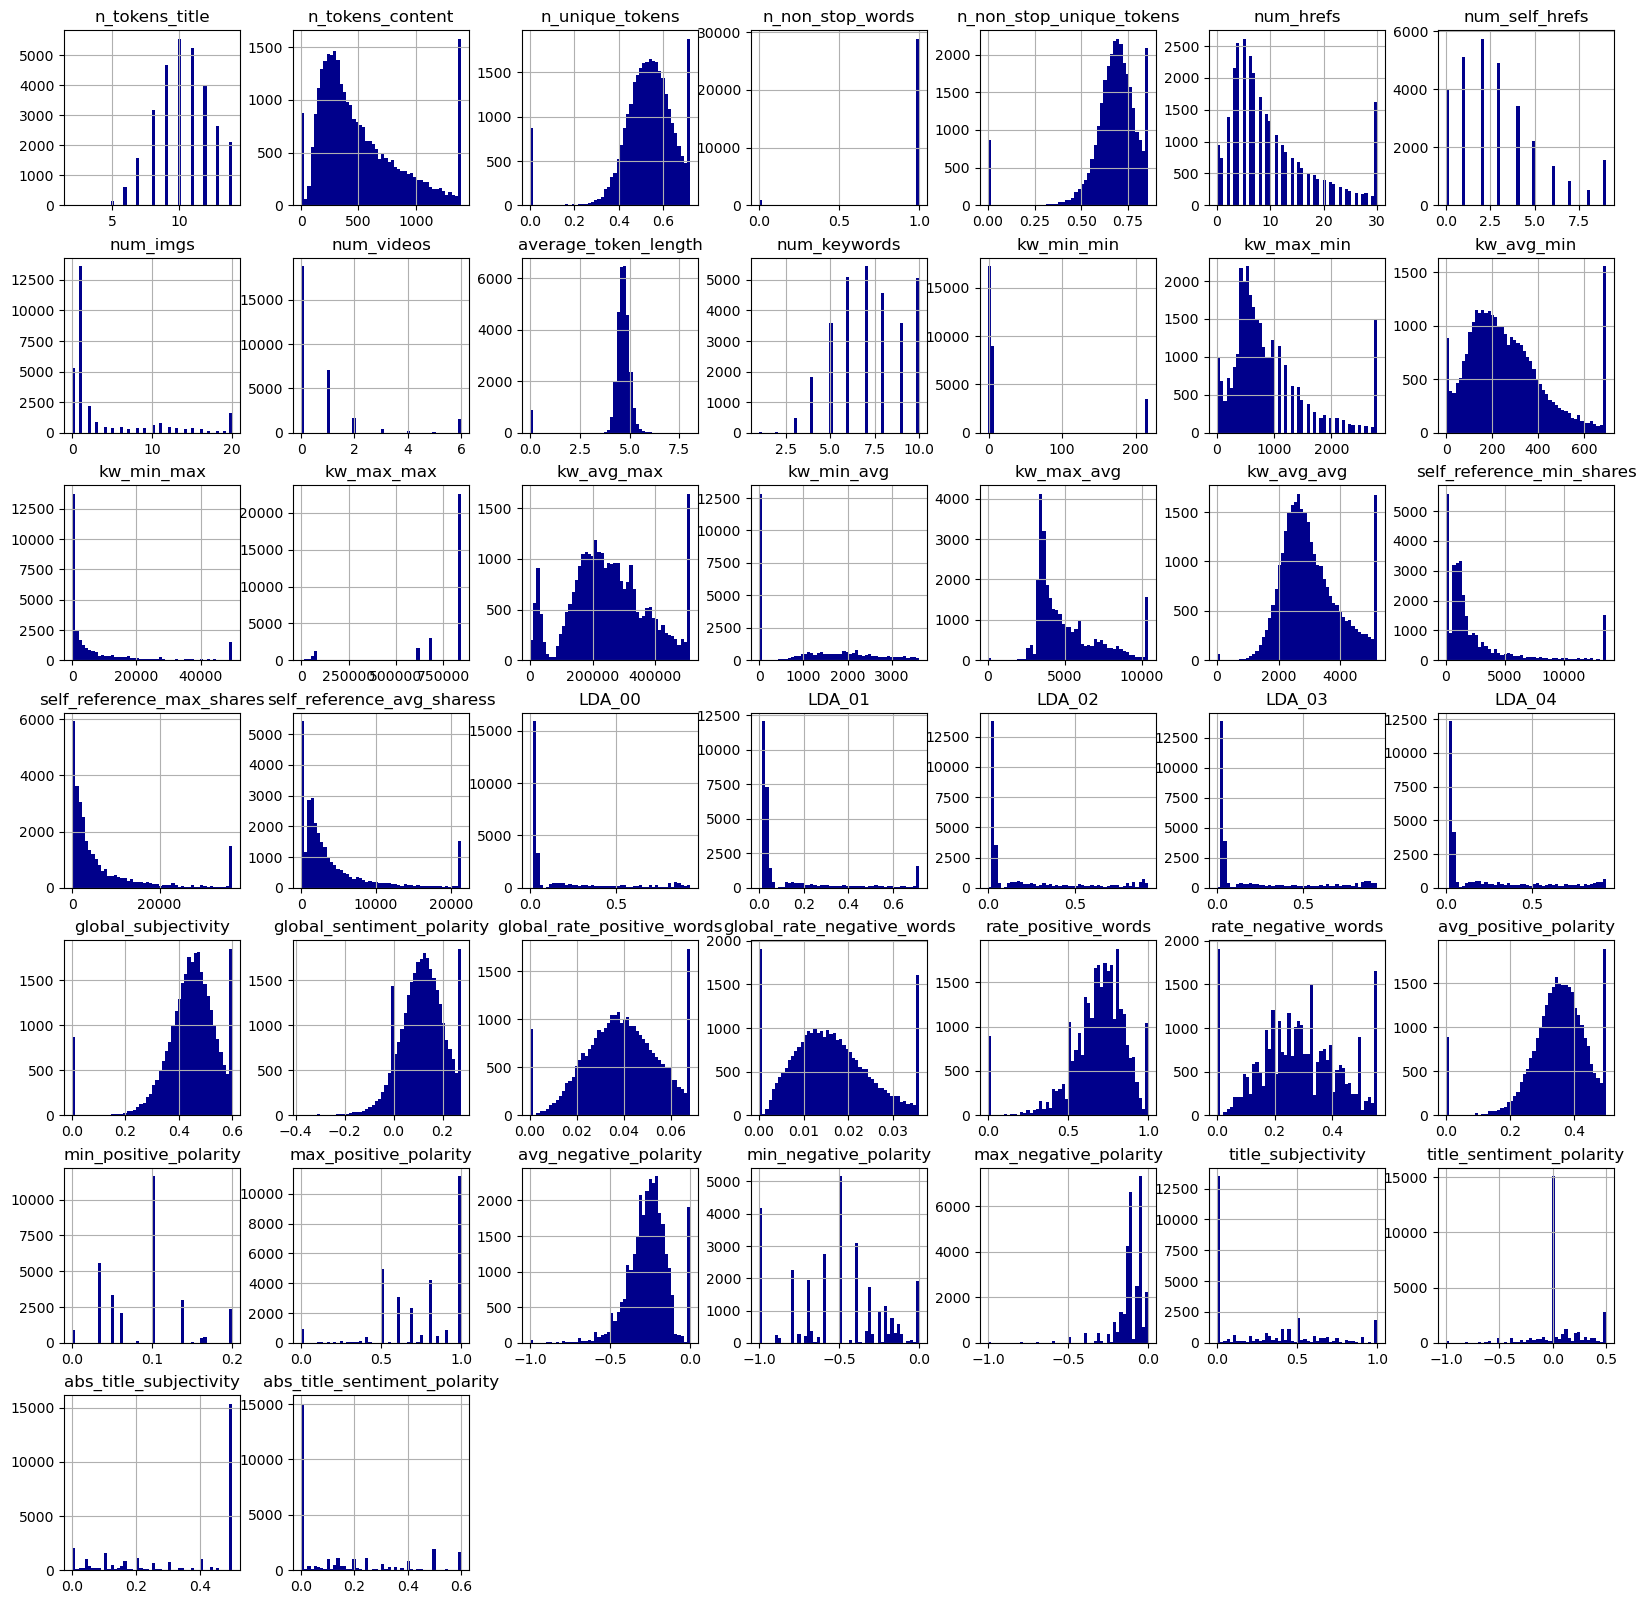

In [23]:
train[numeric_features].hist(figsize=(20, 20), bins=50, color='darkblue')

In [25]:
# based from the previous plots, we could create some logarithmic variables
to_log = ['n_tokens_content','num_hrefs','num_self_hrefs','global_rate_negative_words']

# copy the data so we don't change the original
fe_train, fe_test = train.copy(), test.copy()

# create the log variables
# for column in to_log:
#     train['']

In [ ]:
# class imbalance


# Benchmark Model
I will first create a Random Forest model to serve as my benchmark (no fine tuning, just a simple RF model). Based on my experiences, RF model performs the best, that's why i am choosing it.

This will also serve as a basic to see feature importance.

In [79]:
# Benchmark simple Random Forest model
steps = [
    ("random_forest", RandomForestClassifier(random_state=prng))
]

pipe_rf = Pipeline(steps)

pipe_rf.fit(x_train, y_train)

Pipeline(steps=[('random_forest',
                 RandomForestClassifier(random_state=RandomState(MT19937) at 0x2811078C540))])

In [80]:
pipe_rf.predict_proba(x_val)

array([[0.92, 0.08],
       [0.77, 0.23],
       [0.83, 0.17],
       ...,
       [0.85, 0.15],
       [0.74, 0.26],
       [0.82, 0.18]])

In [81]:
evaluate_model(pipe_rf)

The Validation AUC for the model is 0.6943


In [29]:
create_submission_file(pipe_rf,"benchmark_rf") # this achieves an accuracy of 0.6773 on the y_test

## Basic Feature Importance

In [30]:
# Access the Random Forest model from the pipeline
random_forest_model = pipe_rf.named_steps['random_forest']

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Assuming you have a list of feature names, you can map them to their importances
feature_names = list(x_train.columns)  # Replace X with your feature DataFrame
importance_dict = dict(zip(feature_names, feature_importances))

# Sort the dictionary by importance values (optional)
sorted_importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

# Print or visualize the feature importances
sorted_importance_dict

{'kw_avg_avg': 0.0417031787881326,
 'kw_max_avg': 0.03913998971227021,
 'LDA_03': 0.033244906364451904,
 'average_token_length': 0.030457635649606532,
 'LDA_02': 0.03027527540951869,
 'LDA_00': 0.03001102883927239,
 'LDA_04': 0.029858982628234478,
 'kw_avg_max': 0.02909548967445462,
 'kw_avg_min': 0.02904587492666298,
 'LDA_01': 0.028899135988938136,
 'self_reference_avg_sharess': 0.028402711994118278,
 'n_non_stop_unique_tokens': 0.02776717330905514,
 'n_unique_tokens': 0.027190716547578563,
 'n_tokens_content': 0.026808848436332085,
 'global_subjectivity': 0.026801835684654652,
 'avg_positive_polarity': 0.026766069181145186,
 'avg_negative_polarity': 0.026349207422252358,
 'kw_max_min': 0.026120527640944115,
 'kw_min_avg': 0.025928937427096073,
 'self_reference_min_shares': 0.02561829918298096,
 'global_rate_positive_words': 0.02492685977506098,
 'global_sentiment_polarity': 0.02474123526683555,
 'self_reference_max_shares': 0.02355233479519256,
 'global_rate_negative_words': 0.02268

# Simple Logistic Regression

In [31]:
# illustration on a single binary variable
log_reg_simple = LogisticRegression().fit(x_train[["kw_max_avg"]], y_train)
train_prediction = log_reg_simple.predict_proba(x_train[["kw_max_avg"]])
val_prediction = log_reg_simple.predict_proba(x_val[["kw_max_avg"]])

In [32]:
# check AUC on training
print(roc_auc_score(y_train, [x[1] for x in train_prediction]))
print(roc_auc_score(y_val, [x[1] for x in val_prediction]))

0.6564041354087319
0.6576398111493078


In [33]:
# submission file
y_predicted = log_reg_simple.predict_proba(x_test[["kw_max_avg"]])

log_submission = pd.DataFrame({'article_id': test['article_id'],
                                    'score': [x[1] for x in y_predicted]})

log_submission.to_csv('simple_linear_submission.csv',index=False) # this simple linear has a score of 0.66 in the test when uploaded to Kaggle

# Multi-variate logistic Regression & More Complex Regression Models

## Multivariate logistic regression with standard scaler

In [82]:
# Standardize features (optional but recommended for Logistic Regression)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Initialize and train a logistic regression model
model_lr = LogisticRegression()
model_lr.fit(x_train_scaled, y_train)

# Make predictions
y_pred_lr = model_lr.predict_proba(x_val_scaled)[:, 1]

# Evaluate using ROC AUC score
roc_auc_lr = roc_auc_score(y_val, y_pred_lr)
print("Logistic Regression ROC AUC:", roc_auc_lr)

Logistic Regression ROC AUC: 0.6849014761108957


## LASSO with interactions

In [35]:
# Define the PolynomialFeatures and LogisticRegression components
create_interactions = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

lasso_pipe = Pipeline([
    ('create_interactions', create_interactions),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=prng))
    ])

lasso_pipe

# Now the pipeline includes StandardScaler, PolynomialFeatures, and LogisticRegression
lasso_pipe

Pipeline(steps=[('create_interactions',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('lasso',
                 LogisticRegression(penalty='l1',
                                    random_state=RandomState(MT19937) at 0x2810197BA40,
                                    solver='liblinear'))])

In [36]:
lasso_pipe.fit(x_train, y_train)

c:\Users\Peti\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('create_interactions',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('lasso',
                 LogisticRegression(penalty='l1',
                                    random_state=RandomState(MT19937) at 0x2810197BA40,
                                    solver='liblinear'))])

In [37]:
evaluate_model(lasso_pipe) # 0.6731

The Validation AUC for the model is 0.6764


In [38]:
create_submission_file(lasso_pipe,"lasso_pipe") # this achieves an accuracy of

# Simple Decision Tree

In [83]:


steps = [
    ("tree", tree.DecisionTreeClassifier(max_depth=5, random_state=prng))
]
pipe_tree = Pipeline(steps)

pipe_tree.fit(x_train, y_train)

Pipeline(steps=[('tree',
                 DecisionTreeClassifier(max_depth=5,
                                        random_state=RandomState(MT19937) at 0x2811078C540))])

In [84]:
create_submission_file(pipe_tree,"simple_tree") # this achieves an accuracy of 0.6929 on the y_test

In [85]:
# check AUC on training
evaluate_model(pipe_tree) #0.6783

The Validation AUC for the model is 0.6691


# Random Forest Model

In [26]:
# hyper-parameter tuning

# Number of trees in random forest
n_estimators = [800,900,1000]
# Number of features to consider at every split
max_features = [0.4,0.6]
# Maximum number of levels in tree
max_depth = [12,15,18]
# Minimum number of samples required to split a node
min_samples_split = [3,4,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [800, 900, 1000],
 'max_features': [0.4, 0.6],
 'max_depth': [12, 15, 18],
 'min_samples_split': [3, 4, 5],
 'min_samples_leaf': [2, 4, 6],
 'bootstrap': [True, False]}

In [31]:
# hyper-parameter tuning - fit the models on the full sample
rf = RandomForestClassifier(random_state=prng)

# Define AUC as the scoring metric
auc_scorer = make_scorer(roc_auc_score)

# Random search of parameters, using 5 fold cross validation,
# search across n_iter different combinations, and use all available cores, evaluate by RMSLE
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=5, scoring=auc_scorer, verbose=2, random_state=prng, n_jobs=-1)

# Fit the random search model
rf_random.fit(x_train, y_train)

In [44]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 0.6,
 'max_depth': 15,
 'bootstrap': False}

In [46]:
evaluate_model(rf_random) # 0.7097

The Validation AUC for the model is 0.6928


In [47]:
create_submission_file(rf_random,'random_forest')

In [48]:
# Access the best Random Forest model from the randomized search object
random_forest_model = rf_random.best_estimator_

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Assuming you have a list of feature names, you can map them to their importances
feature_names = list(x_train.columns)  # Replace x_train with your feature DataFrame
importance_dict = dict(zip(feature_names, feature_importances))

# Sort the dictionary by importance values (optional)
sorted_importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

# Print or visualize the feature importances
sorted_importance_dict

{'kw_avg_avg': 0.08419029056286816,
 'kw_max_avg': 0.04995948981194815,
 'average_token_length': 0.03506576979235997,
 'kw_avg_max': 0.03351088132382044,
 'LDA_04': 0.03316673184420534,
 'self_reference_avg_sharess': 0.03169599049909906,
 'LDA_03': 0.03161272763334728,
 'LDA_00': 0.03011272982258944,
 'self_reference_min_shares': 0.02954921783041357,
 'n_unique_tokens': 0.029420902546276904,
 'global_subjectivity': 0.028889671677999697,
 'LDA_02': 0.028887791388184085,
 'kw_avg_min': 0.028827352759148592,
 'LDA_01': 0.02868532539159232,
 'avg_positive_polarity': 0.028089807228486204,
 'n_non_stop_unique_tokens': 0.027686257035787906,
 'n_tokens_content': 0.0274013528375162,
 'global_rate_positive_words': 0.027145476673565486,
 'avg_negative_polarity': 0.026795878563892754,
 'kw_max_min': 0.02558964228626702,
 'kw_min_avg': 0.02555382792540601,
 'global_sentiment_polarity': 0.023706822187924286,
 'num_hrefs': 0.02129721856018768,
 'global_rate_negative_words': 0.02040598881146403,
 'sel

# HistGradient Boosting Model

In [151]:
# Define your AUC scorer
auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Define the parameter grid for GBM
param_grid_gbm = {
    'max_depth': [3, 4, 5, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_leaf_nodes': [10,12,15,20,25],
    'max_bins': [128, 255, 512],
    'l2_regularization': [0.0, 0.1, 0.01, 0.001]
}

# Initialize the GBM classifier
gbm_classifier = HistGradientBoostingClassifier(random_state=prng)

# Random search of parameters using RandomizedSearchCV
gbm_random = RandomizedSearchCV(estimator=gbm_classifier,
                                param_distributions=param_grid_gbm,
                                n_iter=200,
                                cv=5,
                                scoring=auc_scorer,
                                verbose=2,
                                random_state=prng,
                                n_jobs=-1
                                )

# Fit the random search model
gbm_random.fit(x_train, y_train)  # Assuming X_train_scaled and y_train are your training data

# Get the best parameters and best score
"Best Parameters:", gbm_random.best_params_
print("Best AUC Score:", gbm_random.best_score_)

c:\Users\Peti\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\Peti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
385 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
385 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Peti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Peti\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Peti\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Peti\anaconda3\Lib\site-packages\s

Best AUC Score: 0.7132448271709529


In [147]:
gbm_random.best_params_

{'max_leaf_nodes': 10,
 'max_depth': 5,
 'max_bins': 128,
 'learning_rate': 0.1,
 'l2_regularization': 0.01}

In [146]:
evaluate_model(gbm_random) # achieves around 0.7118, 0.7148 with 50 it

The Validation AUC for the model is 0.7114


In [148]:
create_submission_file(gbm_random,'histgbm')

# XGBoost

In [53]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'max_depth': [3, 4, 5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 500, 1000],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 1, 5],
}


# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=prng)

# Define AUC as the scoring metric
auc_scorer = make_scorer(roc_auc_score)

# Random search of parameters using RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb_classifier,
                                param_distributions=param_grid_xgb,
                                n_iter=50,
                                cv=5,
                                scoring=auc_scorer,
                                verbose=2,
                                random_state=prng,
                                n_jobs=-1)

# Fit the random search model
xgb_random.fit(x_train, y_train)

# Get the best parameters and best score
best_params_xgb = xgb_random.best_params_
best_score_xgb = xgb_random.best_score_

print("Best Parameters for XGBoost:", best_params_xgb)
print("Best AUC Score for XGBoost:", best_score_xgb)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best AUC Score for XGBoost: 0.523820822321251


In [54]:
evaluate_model(xgb_random) # achieves around 0.65

The Validation AUC for the model is 0.6721


In [55]:
best_params_xgb

{'subsample': 0.8,
 'reg_lambda': 5,
 'reg_alpha': 0.1,
 'n_estimators': 1000,
 'max_depth': 3,
 'learning_rate': 0.3,
 'gamma': 0.2,
 'colsample_bytree': 0.8}

In [56]:
create_submission_file(xgb_random,'xgboost')

# Neural Netwroks

In [108]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model with binary crossentropy loss and AUC metric
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Binary crossentropy for binary classification
              metrics=['accuracy', tf.keras.metrics.AUC()])  # Use AUC as a metric

# Train the model
history = model.fit(X_train_scaled, y_train,
                    callbacks=[EarlyStopping(monitor='val_auc_26', patience=5,mode='max')], # 5 epochs without any improvement
                    epochs=100,
                    batch_size=150,
                    validation_split=0.2,
                    verbose=1)

# Get model predictions on the validation set
y_val_pred = model.predict(X_val_scaled)

# Calculate AUC score
auc_score = roc_auc_score(y_val, y_val_pred)
print('Validation AUC Score:', auc_score)

Epoch 1/100


c:\Users\Peti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7181 - auc_26: 0.5134 - loss: 0.5949 - val_accuracy: 0.8848 - val_auc_26: 0.6427 - val_loss: 0.3462
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8746 - auc_26: 0.6018 - loss: 0.3935 - val_accuracy: 0.8848 - val_auc_26: 0.6735 - val_loss: 0.3382
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8737 - auc_26: 0.6196 - loss: 0.3826 - val_accuracy: 0.8848 - val_auc_26: 0.6846 - val_loss: 0.3358
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8724 - auc_26: 0.6401 - loss: 0.3775 - val_accuracy: 0.8848 - val_auc_26: 0.6921 - val_loss: 0.3336
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8728 - auc_26: 0.6553 - loss: 0.3724 - val_accuracy: 0.8848 - val_auc_26: 0.6967 - val_loss: 0.3325
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8778 - auc_26: 0.6654 - loss: 0.3616 - val_accuracy: 0.8848 - val_auc_26: 0.7006 - val_loss: 0.3317
Epoch 7/10

In [120]:
# Assuming X_test_scaled is your test data
y_probabilities = model.predict(X_test_scaled)

pd.DataFrame({'article_id': test['article_id'],
              'score': y_probabilities[:, 0]}).to_csv('neural_network.csv',index=False)

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


After careful experimentation, this is the best model i could come up with.